In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_df = pd.read_csv("./CNN ASSIGNMENT/train/train.csv")
train_df

image_id  filename  label
0            1     1.jpg      2
1            2     2.jpg      4
2            3     3.jpg      2
3            4     4.jpg      3
4            5     5.jpg      5
...        ...       ...    ...
7195      7196  7196.jpg      4
7196      7197  7197.jpg      4
7197      7198  7198.jpg      4
7198      7199  7199.jpg      2
7199      7200  7200.jpg      2

[7200 rows x 3 columns]

In [11]:
import os   # To interact with the system
import shutil   # To copy files

def create_dataset(df, label_map, image_dir, new_filepath):
    for index, row in df.iterrows():  # Going through each row in the dataframe
        try:
            filename = row["filename"]  # Get the filename from the row
            label = row["label"]  # Get the label from the row

            # Check if the label is valid
            if label not in label_map:
                print(f"Skipping row {index}: Invalid label '{label}' for file {filename}")
                continue

            # Get the label class from the label_map
            label_class = label_map[label]
            image_path = os.path.join(image_dir, filename)  # Get the full path to the image
            join_dir = os.path.join(new_filepath, label_class)  # Path where the image will be copied

            # Check if the source image exists
            if not os.path.exists(image_path):
                print(f"Skipping {filename}: Source file not found at {image_path}")
                continue

            # Create the destination directory if it doesn't exist
            try:
                os.makedirs(join_dir, exist_ok=True)
            except OSError as e:
                print(f"Error creating directory {join_dir}: {e}")
                continue

            # Create the final path for the image file in the new directory
            join_path = os.path.join(join_dir, filename)

            # Copy the image to the new location
            try:
                shutil.copy2(image_path, join_path)
            except IOError as e:
                print(f"Error copying file {filename} to {join_path}: {e}")
                continue
            except Exception as e:
                print(f"Unexpected error processing row {index}: {e}")
                continue

        except Exception as e:
            print(f"Unexpected error processing row {index}: {e}")
            continue

In [12]:
class_label_mapping = {
    1: "crack", 
    2: "scratch",
    3: "flat tire",
    4: "dent",
    5: "shattered glass",
    6: "lamp broken"}

In [23]:
create_dataset(df=train_df, label_map=class_label_mapping, image_dir="./CNN ASSIGNMENT/train/images", new_filepath ="./CNN ASSIGNMENT/new_train")

In [24]:
from tensorflow.keras.utils import image_dataset_from_directory

image_dataset = image_dataset_from_directory(
    directory="./CNN ASSIGNMENT/new_train",
    labels="inferred",
    label_mode = "int",
    batch_size= 32,
    image_size=(255, 255)
)

Found 7200 files belonging to 6 classes.


['crack', 'dent', 'flat tire', 'lamp broken', 'scratch', 'shattered glass']
Image batch shape: (32, 255, 255, 3)
Label batch shape: (32,)


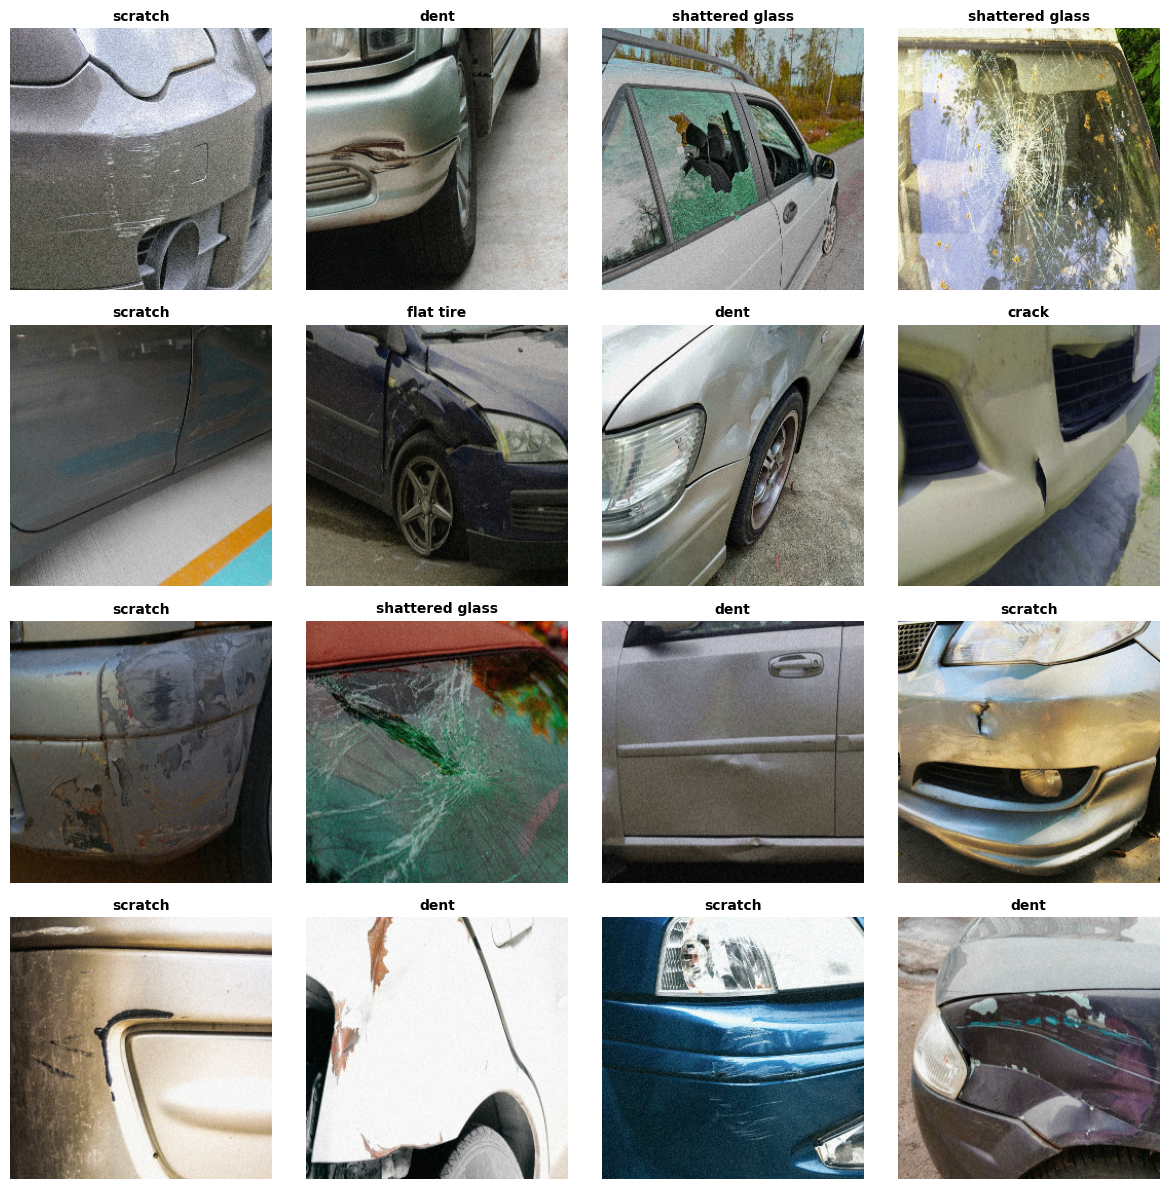

In [15]:
class_names = image_dataset.class_names
print(class_names)

for images, labels in image_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

    figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

    for index, image in enumerate(images[:16]):  # Show the first 16 images
        row = index // 4
        col = index % 4

        ax = axes[row, col]
        ax.imshow(image.numpy().astype(int))
        ax.axis("off")

        # Set title as the class name corresponding to the label
        ax.set_title(class_names[labels[index].numpy()], fontweight="bold", fontsize=10)

    plt.tight_layout()
    plt.show()

In [16]:
def conv_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.extend(image.numpy())
        labels.extend(label.numpy())

    return np.array(images), np.array(labels)

images, labels = conv_to_numpy(image_dataset)

train_images, test_images, train_labels, test_labels= train_test_split(images, labels, random_state=42, test_size=0.2)

print(f"The training test size is: {len(train_images)}")
print(f"The testing size is: {len(test_images)}")

The training test size is: 5754
The testing size is: 1439


In [17]:
train_labels

array([1, 4, 1, ..., 3, 1, 4])

In [18]:
from tensorflow.keras.utils import to_categorical

train_label_cat = to_categorical(train_labels, num_classes=6)
train_label_cat

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [19]:
train_images

array([[[[192.86333   , 193.51038   , 199.41292   ],
         [184.17474   , 186.52768   , 200.23357   ],
         [155.09804   , 162.6707    , 166.22952   ],
         ...,
         [221.10092   , 231.10092   , 232.10092   ],
         [215.76299   , 226.76299   , 218.9395    ],
         [223.70589   , 234.70589   , 226.70589   ]],

        [[184.86449   , 185.92331   , 168.90022   ],
         [188.74048   , 189.82353   , 185.40138   ],
         [187.61015   , 191.61015   , 192.7278    ],
         ...,
         [219.81372   , 229.81372   , 230.44116   ],
         [212.25958   , 223.25958   , 217.25958   ],
         [219.        , 230.        , 222.        ]],

        [[181.05998   , 176.89217   , 154.91464   ],
         [181.97923   , 180.76471   , 160.68512   ],
         [196.21107   , 195.5888    , 189.36794   ],
         ...,
         [221.04901   , 231.04901   , 230.04901   ],
         [220.55884   , 230.55884   , 229.55884   ],
         [221.23529   , 232.23529   , 224.96088   ]],

In [20]:
train_images_norm = train_images / 255
train_images_norm.max()

1.0

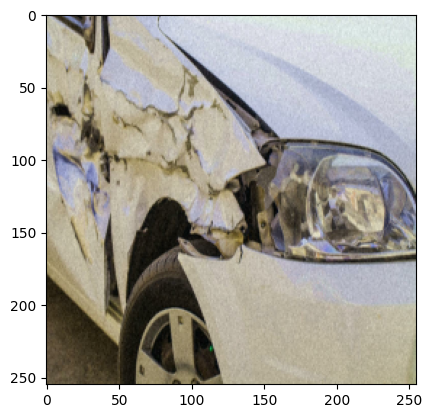

In [21]:
plt.imshow(train_images_norm[0])
plt.show()

## Image Transformation for Augumentation

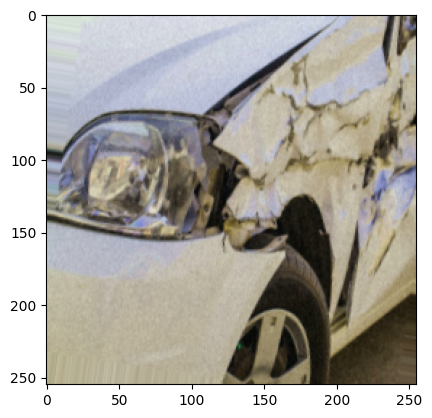

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range =20,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True, 
                                   vertical_flip=False, 
                                   shear_range=0.10, 
                                   zoom_range=0.10,
                                   validation_split=0.2
) 
train_datagen.fit(train_images_norm)

new_image = train_datagen.random_transform(train_images_norm[0])
plt.imshow(new_image)
plt.show()

## CNN model

In [17]:
print("Train images shape:", train_images_norm.shape)
print("Train labels shape:", train_label_cat.shape)

Train images shape: (5760, 255, 255, 3)
Train labels shape: (5760, 6)


In [18]:
model = Sequential()
model.add(Input(shape=(255,255,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# ➡️ Add one more Pooling to shrink the size
model.add(MaxPooling2D(pool_size=(2,2))) 

# Now Flatten
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,936,902 (7.39 MB)

 Trainable params: 1,936,902 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compile the model with SGD optimizer
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Assuming you have train_images_norm and train_label_cat, and using ImageDataGenerator for training and validation splits
history = model.fit(
    train_datagen.flow(train_images_norm, train_label_cat, batch_size=32, subset="training"), 
    epochs=100, 
    validation_data=train_datagen.flow(train_images_norm, train_label_cat, batch_size=32, subset="validation")
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.2965 - loss: 1.6543 - val_accuracy: 0.3125 - val_loss: 1.5335
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.3379 - loss: 1.5486 - val_accuracy: 0.3845 - val_loss: 1.4083
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.3691 - loss: 1.4487 - val_accuracy: 0.4306 - val_loss: 1.3424
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.4079 - loss: 1.3971 - val_accuracy: 0.4115 - val_loss: 1.2829
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.4347 - loss: 1.3294 - val_accuracy: 0.4731 - val_loss: 1.2159
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.4321 - loss: 1.3163 - val_accuracy: 0.4870 - val_loss: 1.2290
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.4408 - loss: 1.2939 - val_accuracy: 0.4601 - val_loss: 1.2485
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.4414 - loss: 1.2658 - 

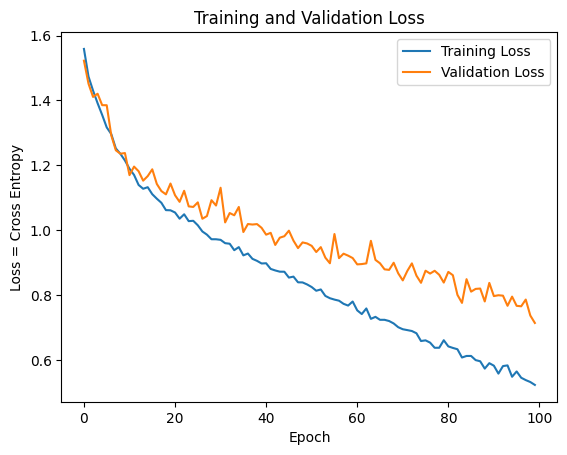

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss = Cross Entropy')
plt.legend()
plt.show()

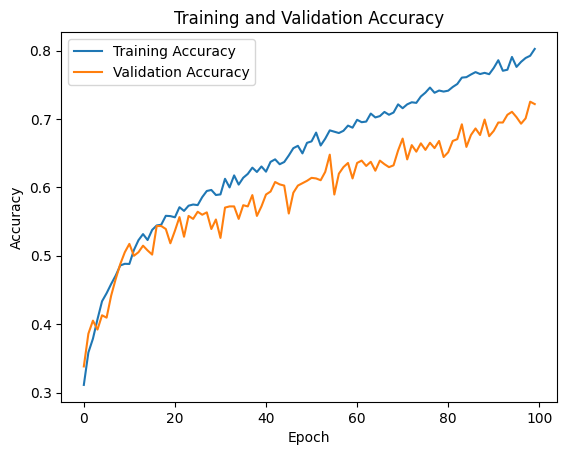

In [43]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [44]:
y_pred = np.argmax(model.predict(train_images_norm), axis=-1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step


In [45]:
from sklearn.metrics import classification_report
# Print the classification report
print(classification_report(train_labels, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       136
           1       0.92      0.76      0.83      1664
           2       0.94      0.96      0.95       439
           3       0.88      0.89      0.89       702
           4       0.82      0.93      0.87      1866
           5       0.95      0.98      0.96       947

    accuracy                           0.88      5754
   macro avg       0.89      0.87      0.88      5754
weighted avg       0.89      0.88      0.88      5754



<Figure size 2000x3000 with 0 Axes>

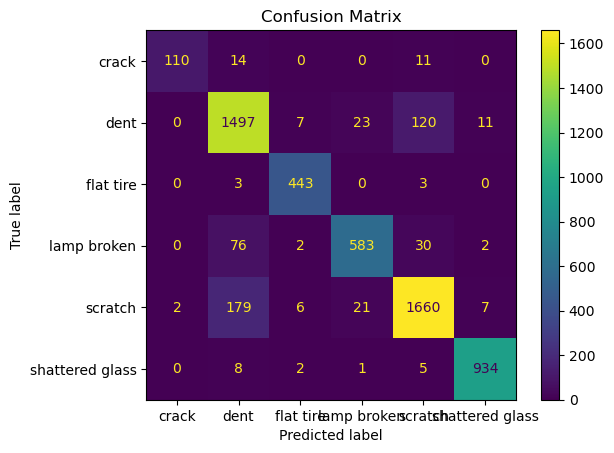

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(train_labels,y_pred, display_labels=class_names)
plt.title('Confusion Matrix')
plt.show()

## Model 2

In [70]:
model = Sequential()
model.add(Input(shape=(255,255,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Now Flatten
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,466,502 (28.48 MB)

 Trainable params: 7,466,502 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Compile the model with SGD optimizer
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Assuming you have train_images_norm and train_label_cat, and using ImageDataGenerator for training and validation splits
history = model.fit(
    train_datagen.flow(train_images_norm, train_label_cat, batch_size=32, subset="training"), 
    epochs=150, 
    validation_data=train_datagen.flow(train_images_norm, train_label_cat, batch_size=32, subset="validation")
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.3093 - loss: 1.6449 - val_accuracy: 0.3229 - val_loss: 1.5100
Epoch 2/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.3203 - loss: 1.5517 - val_accuracy: 0.3793 - val_loss: 1.4695
Epoch 3/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.3622 - loss: 1.4728 - val_accuracy: 0.3316 - val_loss: 1.4728
Epoch 4/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.3748 - loss: 1.4434 - val_accuracy: 0.4089 - val_loss: 1.3313
Epoch 5/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.3784 - loss: 1.4407 - val_accuracy: 0.3967 - val_loss: 1.3717
Epoch 6/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.4026 - loss: 1.4008 - val_accuracy: 0.4262 - val_loss: 1.3225
Epoch 7/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.4193 - loss: 1.3681 - val_accuracy: 0.4332 - val_loss: 1.3096
Epoch 8/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.4240 - loss: 1.3434 - 

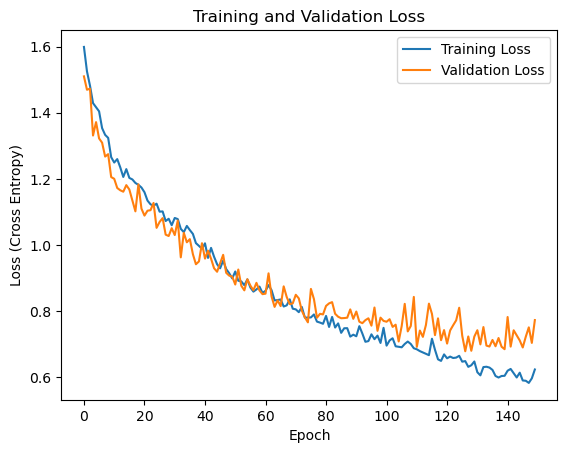

In [77]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

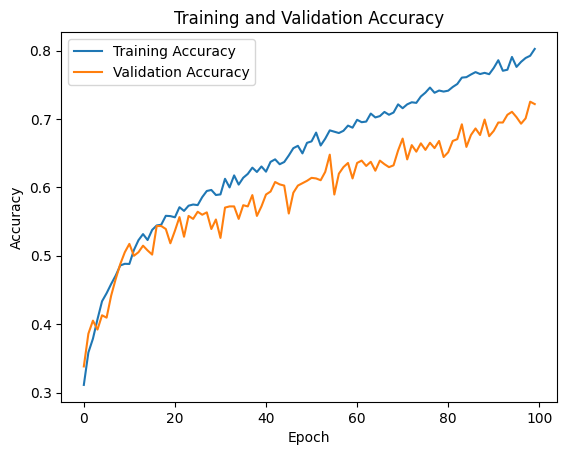

In [46]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [81]:
y_pred = np.argmax(model.predict(train_images_norm), axis=-1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 79s 432ms/step


In [83]:
print(classification_report(train_labels, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.74      0.83       135
           1       0.87      0.80      0.83      1658
           2       0.92      0.97      0.94       449
           3       0.84      0.86      0.85       693
           4       0.83      0.88      0.85      1875
           5       0.95      0.96      0.96       950

    accuracy                           0.87      5760
   macro avg       0.89      0.87      0.88      5760
weighted avg       0.87      0.87      0.87      5760



<Figure size 2000x3000 with 0 Axes>

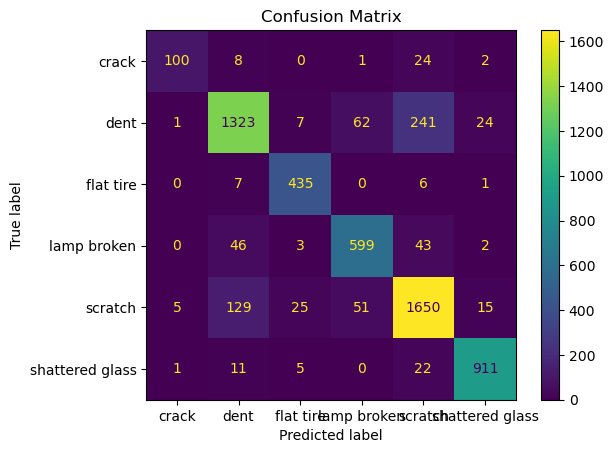

In [85]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(train_labels,y_pred, display_labels=class_names)
plt.title('Confusion Matrix')
plt.show()

## Model 3

In [25]:
model = Sequential()
model.add(Input(shape=(255,255,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Now Flatten
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 255, 255, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,502 (28.48 MB)

 Trainable params: 7,466,502 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Compile the model with SGD optimizer
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Assuming you have train_images_norm and train_label_cat, and using ImageDataGenerator for training and validation splits
history = model.fit(
    train_datagen.flow(train_images_norm, train_label_cat, batch_size=32, subset="training"), 
    epochs=100, 
    validation_data=train_datagen.flow(train_images_norm, train_label_cat, batch_size=32, subset="validation")
)

Epoch 1/100


C:\Program Files\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 56s 378ms/step - accuracy: 0.2774 - loss: 1.6648 - val_accuracy: 0.3070 - val_loss: 1.5560
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 58s 392ms/step - accuracy: 0.3266 - loss: 1.5607 - val_accuracy: 0.3461 - val_loss: 1.5200
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 60s 406ms/step - accuracy: 0.3464 - loss: 1.5245 - val_accuracy: 0.3304 - val_loss: 1.5059
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 426ms/step - accuracy: 0.3658 - loss: 1.4976 - val_accuracy: 0.3930 - val_loss: 1.4490
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 60s 410ms/step - accuracy: 0.3746 - loss: 1.4552 - val_accuracy: 0.3939 - val_loss: 1.4305
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 56s 385ms/step - accuracy: 0.3728 - loss: 1.4575 - val_accuracy: 0.3922 - val_loss: 1.4017
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 427ms/step - accuracy: 0.3912 - loss: 1.4493 - val_accuracy: 0.3957 - val_loss: 1.3971
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 425ms/step - accuracy: 0.3817 - loss: 1.416

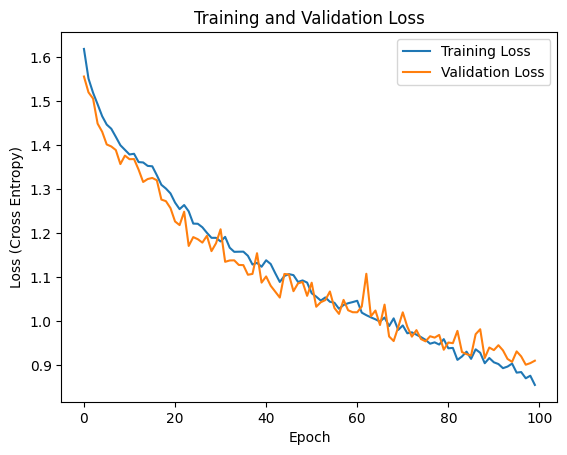

In [27]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

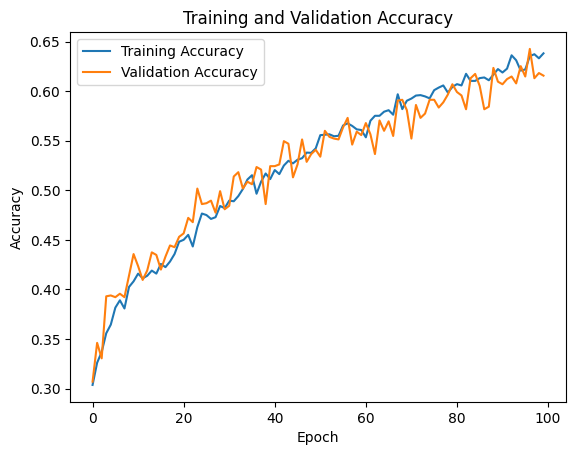

In [28]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
y_pred = np.argmax(model.predict(train_images_norm), axis=-1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step


In [30]:
print(classification_report(train_labels, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.69      0.59      0.64      1664
           2       0.94      0.84      0.89       439
           3       0.63      0.70      0.66       702
           4       0.69      0.75      0.72      1866
           5       0.82      0.96      0.88       947

    accuracy                           0.72      5754
   macro avg       0.63      0.64      0.63      5754
weighted avg       0.70      0.72      0.71      5754



C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 2000x3000 with 0 Axes>

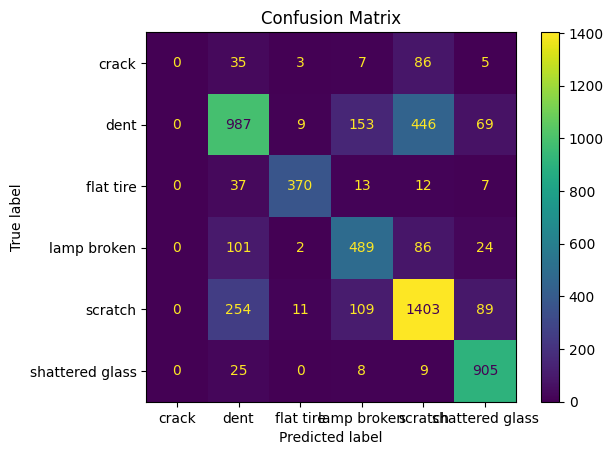

In [31]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(train_labels,y_pred, display_labels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [33]:
model = Sequential()
model.add(Input(shape=(255,255,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Now Flatten
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 255, 255, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,502 (28.48 MB)

 Trainable params: 7,466,502 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Assuming you have train_images_norm and train_label_cat, and using ImageDataGenerator for training and validation splits
history = model.fit(
    train_datagen.flow(train_images_norm, train_label_cat, batch_size=32, subset="training"), 
    epochs=100, 
    validation_data=train_datagen.flow(train_images_norm, train_label_cat, batch_size=32, subset="validation")
)

Epoch 1/100


C:\Program Files\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 57s 382ms/step - accuracy: 0.3076 - loss: 1.6018 - val_accuracy: 0.3383 - val_loss: 1.5226
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 60s 408ms/step - accuracy: 0.3435 - loss: 1.5016 - val_accuracy: 0.3861 - val_loss: 1.4518
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 60s 409ms/step - accuracy: 0.3855 - loss: 1.4303 - val_accuracy: 0.4052 - val_loss: 1.4109
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 60s 407ms/step - accuracy: 0.4031 - loss: 1.3964 - val_accuracy: 0.3922 - val_loss: 1.4208
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 57s 391ms/step - accuracy: 0.4347 - loss: 1.3638 - val_accuracy: 0.4130 - val_loss: 1.3856
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 58s 396ms/step - accuracy: 0.4457 - loss: 1.3149 - val_accuracy: 0.4096 - val_loss: 1.3854
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 413ms/step - accuracy: 0.4547 - loss: 1.2859 - val_accuracy: 0.4417 - val_loss: 1.2924
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 415ms/step - accuracy: 0.4672 - loss: 1.259

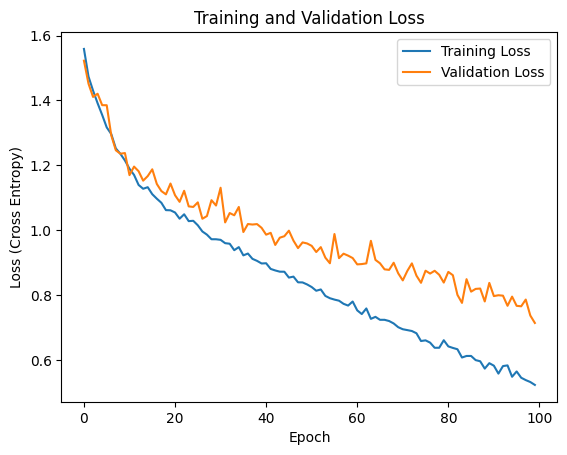

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

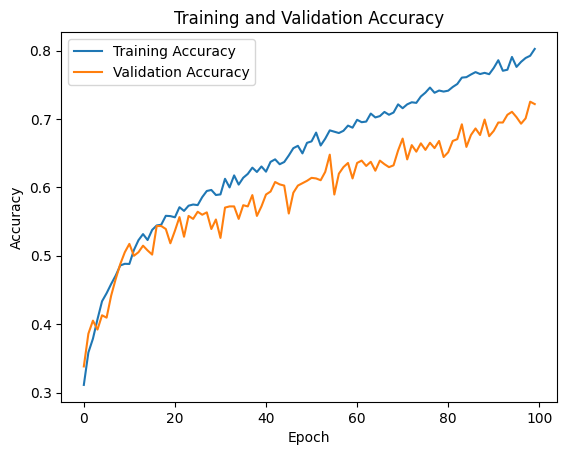

In [47]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
y_pred = np.argmax(model.predict(train_images_norm), axis=-1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step


In [49]:
print(classification_report(train_labels, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       136
           1       0.92      0.76      0.83      1664
           2       0.94      0.96      0.95       439
           3       0.88      0.89      0.89       702
           4       0.82      0.93      0.87      1866
           5       0.95      0.98      0.96       947

    accuracy                           0.88      5754
   macro avg       0.89      0.87      0.88      5754
weighted avg       0.89      0.88      0.88      5754



<Figure size 2000x3000 with 0 Axes>

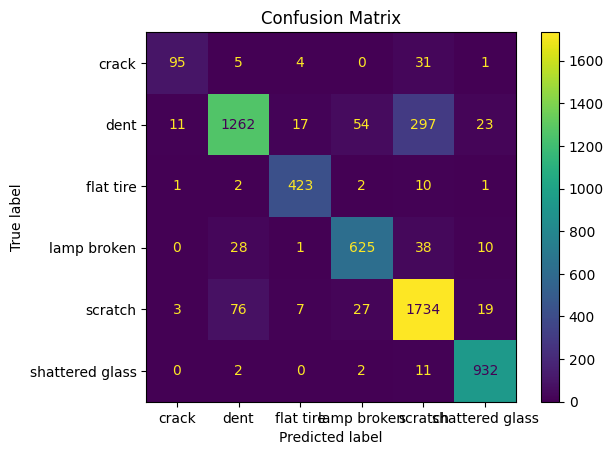

In [50]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(train_labels,y_pred, display_labels=class_names)
plt.title('Confusion Matrix')
plt.show()